# Simple OpenPulse tutorials

First, just some imports

In [1]:
from qiskit import IBMQ, pulse, QuantumCircuit, transpile, schedule, assemble
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag
import numpy as np

# IBM Account
Loading up the IBM account settings

Note: change provider opts data

In [2]:
IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}
provider = IBMQ.get_provider(**provider_opts)

Here we are getting the reference to the backend. 
I just picked Bogota for no reason at all.

Here we also go ahead and get references to some important data structures when working with OpenPulse. 

These are the **PulseBackendConfiguration, PulseDefaults, InstructionScheduleMap** objects

In [3]:
# Just picked Bogota for no reason
backend = provider.get_backend('ibmq_jakarta')

#  This contains information about the set up of the device which can be useful for building Pulse programs.
config = backend.configuration()

# Description of default settings for Pulse systems. 
# These are instructions or settings that may be good starting points for the Pulse user.
defaults = backend.defaults()

# This is very important - it describes the mappings between the gates available on qubits to the Pulse schedules that generate them
# This contains the specific Pulse schedules, calibrated by IBM, for the basis gates available on this backend
inst_map = defaults.instruction_schedule_map

Uncomment below to see what basis gates are available on each of the qubits for this device

note: although they will list *u1, u2, u3, cx* I believe all devices have moved to *rz, x, sx, cx*

In [4]:
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'u2', 'rz', 'measure', 'x', 'u3', 'sx', 'u1', 'id'}
  q1: {'u2', 'rz', 'measure', 'x', 'u3', 'sx', 'u1', 'id'}
  q2: {'u2', 'rz', 'measure', 'x', 'u3', 'sx', 'u1', 'id'}
  q3: {'u2', 'rz', 'measure', 'x', 'u3', 'sx', 'u1', 'id'}
  q4: {'u2', 'rz', 'measure', 'x', 'u3', 'sx', 'u1', 'id'}
  q5: {'u2', 'rz', 'measure', 'x', 'u3', 'sx', 'u1', 'id'}
  q6: {'u2', 'rz', 'measure', 'x', 'u3', 'sx', 'u1', 'id'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 5): {'cx'}
  (4, 5): {'cx'}
  (5, 3): {'cx'}
  (5, 4): {'cx'}
  (5, 6): {'cx'}
  (6, 5): {'cx'}
  (0, 1, 2, 3, 4, 5, 6): {'measure'}
)>


Here is where you can see the official basis gates the *backend*, using the *BackendConfiguration*

In [5]:
print(config.basis_gates)

['id', 'rz', 'sx', 'x', 'cx', 'reset']


# From gates to schedules
Here we go through turning a quantum circuit into a pulse schedule.

Start with a Bell state circuit

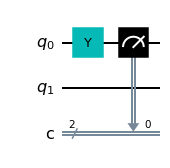

In [7]:
q1, q2 = 1,2

qc = QuantumCircuit(2, 2)
qc.y(0)
# qc.h(0)
# qc.cx(0, 1)
qc.measure(0,0)
qc.draw('mpl')

Since the Hadamard gate is not one of our basis gates, we need to transpile the circuit *before* we see its pulse form

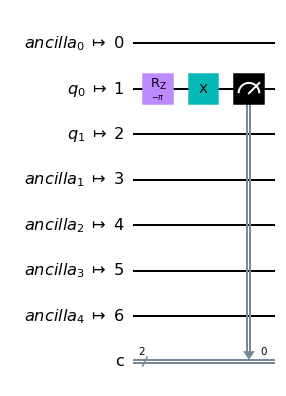

In [8]:
transpiled_bell_state = transpile(qc, backend, initial_layout=[q1,q2])
transpiled_bell_state.draw('mpl')

Each device is different with different calibrations for their basis gates, so in order to see a particular pulse schedule, we also need to *schedule* the transpiled circuit using the *backend* object

In [10]:
bell_state_schedule = schedule(transpiled_bell_state, backend)
bell_state_schedule.draw()
for inst in bell_state_schedule.instructions:
    print(inst)

(0, ShiftPhase(3.14159265358979, DriveChannel(1)))
(0, ShiftPhase(3.14159265358979, ControlChannel(0)))
(0, ShiftPhase(3.14159265358979, ControlChannel(4)))
(0, ShiftPhase(3.14159265358979, ControlChannel(5)))
(0, Play(Drag(duration=160, amp=(0.1918118447936648+0j), sigma=40, beta=-0.9901596406391232, name='Xp_d1'), DriveChannel(1), name='Xp_d1'))
(160, Acquire(22400, AcquireChannel(1), MemorySlot(0)))
(160, Play(GaussianSquare(duration=22400, amp=(-0.12869780599362984-0.14716359853043148j), sigma=64, width=22144, name='M_m1'), MeasureChannel(1), name='M_m1'))
(22560, Delay(1680, MeasureChannel(1)))


There's a lot going on here, but the gist of this small example is this: the logical gates in our circuit are mapped to basis gates by the transpiler which are then further mapped to pulse schedules by the scheduler. The logical gates can be decomposed to single or multiple basis gates and the basis gates can be decomposed to single or multiple pulses.

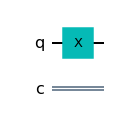

In [45]:
q1, q2 = 1,2

qc = QuantumCircuit(1, 1)
qc.x(0)
# qc.cx(0, 1)
# qc.measure(0,0)
qc.draw('mpl')

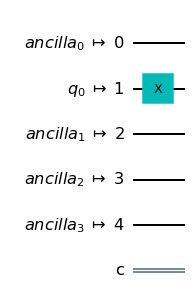

In [46]:
tc = transpile(qc, backend, initial_layout=[q1])
tc.draw('mpl')

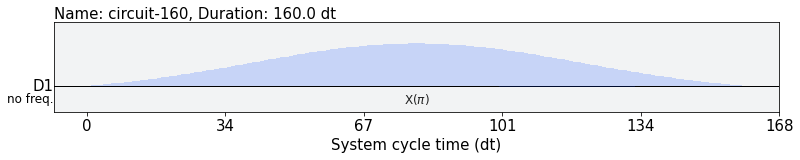

In [47]:
x_sched = schedule(tc, backend)
x_sched.draw()

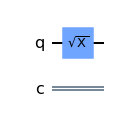

In [48]:
q1, q2 = 1,2

qc = QuantumCircuit(1, 1)
qc.sx(0)
# qc.cx(0, 1)
# qc.measure(0,0)
qc.draw('mpl')

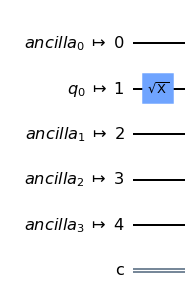

In [49]:
tc = transpile(qc, backend, initial_layout=[q1])
tc.draw('mpl')

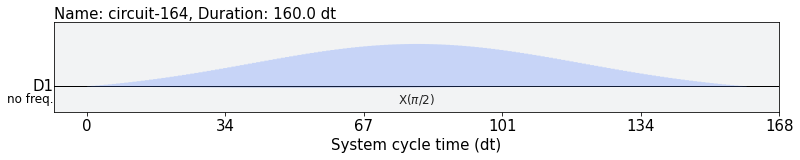

In [50]:
sx_sched = schedule(tc, backend)
sx_sched.draw()

In [51]:
for inst in x_sched.instructions:
    print(inst)

(0, Play(Drag(duration=160, amp=(0.17254829276232347+0j), sigma=40, beta=0.7042487469880645, name='Xp_d1'), DriveChannel(1), name='Xp_d1'))


In [52]:
for inst in sx_sched.instructions:
    print(inst)

(0, Play(Drag(duration=160, amp=(0.08629059243459763-0.001260801834752824j), sigma=40, beta=-0.7929174446372534, name='X90p_d1'), DriveChannel(1), name='X90p_d1'))


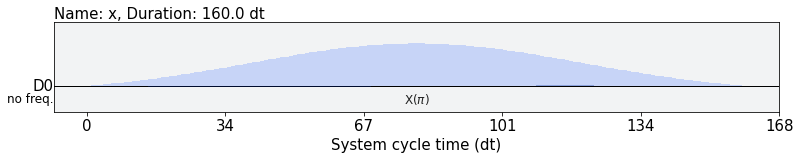

In [54]:
x_gate = inst_map.get("x", 0)
x_gate.draw()